# COGS118B Final Project: Clustering analysis on Amazon Video Game Reivews

### Kevin Ma


## Introduction On Motivation

As someone who is passionate about video games and Natural Language Processing (NLP), I wanted to explore how machine learning techniques could be applied to understand consumer opinions on game-related products. Clustering analysis on Amazon reviews from the video game category offers an interesting opportunity to leverage both unsupervised and supervised learning to uncover hidden patterns and insights in customer feedback. The ability to classify and analyze user-generated content could reveal trends in customer sentiment, common issues, and emerging preferences in gaming products as gaming is becoming a more daily life way to entertain.

For this project, I used an open dataset from UCSD McAuley Lab, which contains Amazon reviews spanning from May 1996 to September 2023. Initially, I planned to analyze laptop reviews, especially after buying a new laptop this Thanksgiving. However, the electronic category contains around 1.7 billion reviews, and downloading the entire dataset would have taken several days. As a result, I decided to focus on the video game category, which still provides a rich and manageable dataset for meaningful analysis.

## Related Work

After thinking more about this topic, I realized that directly clustering on text itself is a challenging task, as raw text lacks a clear structure for algorithms to interpret. Converting the text into vectors, however, provides a structured representation of the content, making clustering analysis more feasible. With this in mind, I explored various methods for text vectorization and found that using TF-IDF (Term Frequency-Inverse Document Frequency) was an effective solution. TF-IDF helps transform textual data into numerical vectors that reflect the importance of words in relation to a document and across a corpus. By giving higher weights to words that are more distinctive and less frequent, TF-IDF reduces the influence of common words, improving clustering results.

To implement this, I referred to the paper "An Improved Text Sentiment Classification Model Using TF-IDF and Next Word Negation" by Bijoyan, which introduced a method for enhancing text classification with TF-IDF. By applying the TF-IDF formulas listed below, the scikit-learn package function was able to assign a maximum number of features to capture the most relevant terms from each review in the dataset. The following two formulas allowed me to convert all the text within the dataset into vectors, which then served as input for the clustering algorithms. This process of converting text to vectors and applying clustering based on those vectors was far more efficient and yielded clearer groupings based on review content.

$$
TFIDF(word,doc) = TF(word,doc) * IDF(word) 
$$
$$
TF(word,doc) = \dfrac{Frequency of word \in the doc}{No.ofwords \in the doc}
$$
$$
IDF(word) = \log_e(1+\dfrac{No.of docs}{No.ofdocswithword})
$$

## Clustering Analysis on Randomly selected Amazon Reviews for Video Game Category

### Preprocess the Data
Randomly select 50,000 reivews from the dataset then use tools to conver the JSON line file to csv file as we are using dataframe as our main data structure

```python
import json
import os
import random

home_dir = os.path.expanduser("~")
downloads_dir = os.path.join(home_dir, "Downloads")
input_file = os.path.join(downloads_dir, "Video_Games.jsonl")
output_file = os.path.join(downloads_dir, "Video_Games_sampled.jsonl")

num_lines_to_keep = 50000

fields_to_remove = ["title","helpful_vote", "images", "parent_asin", "user_id", "verified_purchase", "timestamp"]

with open(input_file, 'r') as infile:
    records = [json.loads(line.strip()) for line in infile]

random.shuffle(records)
sampled_records = records[:num_lines_to_keep]

for record in sampled_records:
    for field in fields_to_remove:
        record.pop(field, None) 

with open(output_file, 'w') as outfile:
    for record in sampled_records:
        outfile.write(json.dumps(record) + '\n')


Then we apply NLTK package to tokendize the review texts and remove all the stopwords. Where stopwords like "I", "the" and other words have no actual influence or meaning on the text but appear a lot in writing.

```python
import nltk
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the list of stopwords
stop_words = set(stopwords.words('english'))

# Load CSV file
df = pd.read_csv('video_games.csv')

# Function to clean text
def clean_text(text):
    if not isinstance(text, str): 
        return ''  
    
    # Remove "I've", "I'm" and possessives like "'s"
    text = re.sub(r"\b(?:I've|I'm|can't|won't|wasn't|weren't|don't|doesn't|didn't)\b", '', text)
    text = re.sub(r"'s\b", '', text) 
    
    # Remove emojis using regex pattern
    text = re.sub(r'[^\w\s,]', '', text) 

    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords and punctuation
    cleaned_words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
    
    # Join the cleaned words back into a single string
    return ' '.join(cleaned_words)


df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))

df = df[df['cleaned_text'].str.strip() != '']

df = df.dropna()

df.to_csv('cleaned_file.csv', index=False)


### Apply K-Means Clustering

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # For reducing dimensionality for visualization

In [2]:
df = pd.read_csv('cleaned_file.csv')
df = df.dropna()

Here we only want to keep the words that appear several times but not a lot of times in the dataset so it is meaningful to vectorizer the words as vectors

In [3]:
vectorizer = vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, max_features=20000)

X = vectorizer.fit_transform(df['cleaned_text'])

After we vectorize all the review texts, to further imply our clustering analysis, I want to first find the right number of clusters. After trying the elbow method, I found out that the sum of square for all clusters is huge since review text have various kinds of length and have different writing styles. As elbow method cannot work well, I changed the method to Silhouette Score as this can measure the right number of cluster when elbow method cannot generate a good number for clustering

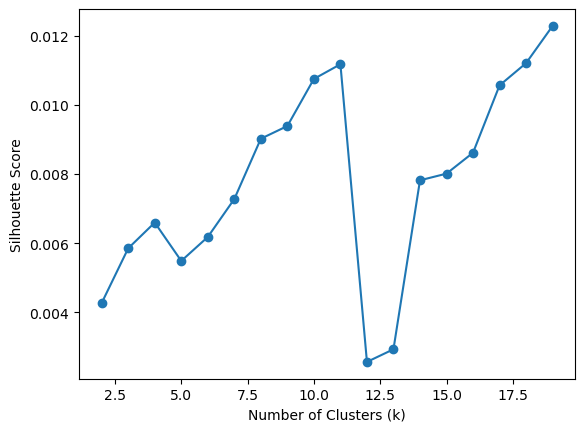

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
import matplotlib.pyplot as plt
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


After applying the silhouette scores as the method to determine the best K value for our K-means clustering, it is clear that 20 is the best choice as having the highest Silhouette score. Therefore, in the following cell I run a K-means clustering with 20 clusters.

In [5]:
# Define the number of clusters (k)
num_clusters = 20

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the DataFrame
df['cluster'] = kmeans.labels_

After clustering, since vectors are high-dimensional data that is hard to visualize, I use PCA to calculate the 2 main components as the way to reduce dimensions.

In [6]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df['cluster']

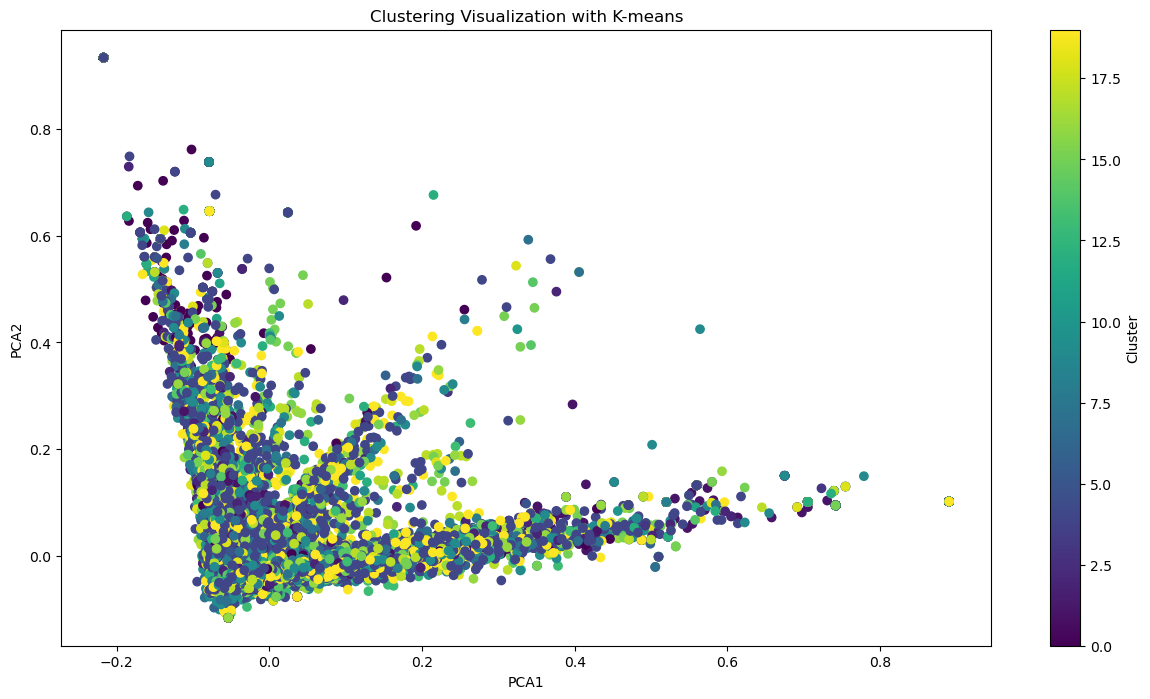

In [7]:
# Plot the clusters
plt.figure(figsize=(15, 8))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['Cluster'], cmap='viridis')
plt.title('Clustering Visualization with K-means')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()

Above is the graph for all clusters after using PCA to reduce dimension. We can see that there is not much difference between all clusters. In order to fully tell the difference in each cluster and analysis on what feature affect high or low rating, we need to identify what kind of product in the Video Game category is in each different cluster and what feature they share in common.

In [8]:
cluster_summary = df.groupby('cluster').agg(
    average_rating=('rating', 'mean'), 
    data_count=('rating', 'count')  
).reset_index()

print(cluster_summary)

    cluster  average_rating  data_count
0         0        4.706016         881
1         1        4.923152        1028
2         2        4.221277        1645
3         3        4.812308         325
4         4        3.863172       18505
5         5        4.972067         358
6         6        4.886210        1037
7         7        3.675676        2627
8         8        4.861148         749
9         9        3.944911        5482
10       10        4.878613         346
11       11        4.796438         393
12       12        4.400952        1050
13       13        4.929215         777
14       14        4.666667         888
15       15        4.844376        1298
16       16        4.009091        2640
17       17        3.902235        2506
18       18        2.532110        1308
19       19        4.026303        6007


In [9]:
# Extract top terms from each cluster
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_center = kmeans.cluster_centers_[i]
    top_terms = [terms[idx] for idx in cluster_center.argsort()[-10:][::-1]]
    print(", ".join(top_terms))

Cluster 0:
good, product, game, price, quality, far, deal, pretty, really, stuff
Cluster 1:
great, game, product, price, worked, item, quality, gift, buy, value
Cluster 2:
case, switch, nintendo, fits, fit, great, dock, screen, games, perfect
Cluster 3:
described, exactly, item, product, works, fast, came, shipping, arrived, great
Cluster 4:
great, product, perfect, one, good, worked, use, awesome, easy, gift
Cluster 5:
excellent, product, condition, game, quality, price, great, shipping, recommend, seller
Cluster 6:
loves, son, daughter, game, old, bought, great, gift, year, husband
Cluster 7:
controller, xbox, one, great, works, controllers, use, like, buttons, good
Cluster 8:
loved, grandson, loves, gift, son, game, christmas, bought, kids, great
Cluster 9:
games, br, game, like, one, play, get, really, fun, much
Cluster 10:
exactly, needed, expected, wanted, advertised, product, looking, works, great, perfect
Cluster 11:
nice, product, game, good, works, really, well, price, great,

### Analysis on Top terms in each cluster

#### Cluster 1
Average Rating: 4.92

Data Count: 1,028

Keywords: great, game, product, price, worked, item, quality, gift, buy, value

Analysis:
This cluster has one of the highest average ratings. Keywords like "great" and "gift" suggest a high level of customer satisfaction, possibly with products that exceeded expectations, often purchased as gifts. Strong associations with "value" and "quality" further indicate premium satisfaction.

#### Cluster 2
Average Rating: 4.22

Data Count: 1,645

Keywords: case, switch, nintendo, fits, fit, great, dock, screen, games, perfect

Analysis:
This cluster likely revolves around accessories for Nintendo Switch, with specific mentions of "case" and "dock." While the average rating is decent, it’s lower than many others, indicating room for improvement in fit or compatibility issues.

#### Cluster 3
Average Rating: 4.81

Data Count: 325

Keywords: described, exactly, item, product, works, fast, came, shipping, arrived, great

Analysis:
Reviews here focus on the accuracy of product descriptions and efficient delivery. The high average rating shows satisfaction with reliability in meeting customer expectations.

#### Cluster 4
Average Rating: 3.86

Data Count: 18,505

Keywords: great, product, perfect, one, good, worked, use, awesome, easy, gift

Analysis:
Despite the large volume of reviews, the average rating is relatively low. This could point to inconsistency in product quality. Keywords such as "worked" and "easy" suggest functional but possibly not outstanding products.

#### Cluster 5
Average Rating: 4.97

Data Count: 358

Keywords: excellent, product, condition, game, quality, price, great, shipping, recommend, seller

Analysis:
This is the highest-rated cluster. Reviews emphasize excellence in product quality and shipping. These are likely top-tier items, well-packaged, and delivered by reliable sellers.

#### Cluster 6
Average Rating: 4.89

Data Count: 1,037

Keywords: loves, son, daughter, game, old, bought, great, gift, year, husband

Analysis:
A very family-oriented cluster, these reviews often mention children and gifts. The high rating suggests satisfaction with products purchased for loved ones, likely games or toys.

#### Cluster 7
Average Rating: 3.68

Data Count: 2,627

Keywords: controller, xbox, one, great, works, controllers, use, like, buttons, good

Analysis:
Low ratings might stem from issues with Xbox controllers or similar accessories. Keywords like "buttons" and "works" suggest functional problems or unmet expectations in durability or usability.

#### Cluster 8
Average Rating: 4.86

Data Count: 749

Keywords: loved, grandson, loves, gift, son, game, christmas, bought, kids, great

Analysis:
Like Cluster 6, this is gift-oriented but with a focus on younger recipients like grandchildren. High ratings indicate satisfaction with the products’ suitability as gifts for children.

#### Cluster 9
Average Rating: 3.94

Data Count: 5,482

Keywords: games, br, game, like, one, play, get, really, fun, much

Analysis:
Reviews focus on general gaming experiences, with mixed satisfaction. The relatively lower rating could indicate issues with gameplay, game availability, or quality.

#### Cluster 10
Average Rating: 4.88

Data Count: 346

Keywords: exactly, needed, expected, wanted, advertised, product, looking, works, great, perfect

Analysis:
This cluster highlights customer satisfaction with products meeting their precise needs. High ratings reflect that items are as advertised and fulfill expectations.

#### Cluster 11
Average Rating: 4.80

Data Count: 393

Keywords: nice, product, game, good, works, really, well, price, great, fit

Analysis:
A strong focus on functional products at reasonable prices. The high rating indicates a general sense of satisfaction, with no major issues.

#### Cluster 12
Average Rating: 4.40

Data Count: 1,050

Keywords: recommend, would, highly, product, great, anyone, definitely, game, good, works

Analysis:
Reviews often emphasize recommendations to others, suggesting high confidence in the products. The moderate rating indicates occasional dissatisfaction.

#### Cluster 13
Average Rating: 4.93

Data Count: 777

Keywords: love, kids, game, great, son, product, boys, much, absolutely, gift

Analysis:
This cluster combines themes of family, children, and gifts with excellent ratings. Products likely bring joy, particularly for younger users.

#### Cluster 14
Average Rating: 4.67
Data Count: 888
Keywords: fun, game, play, great, family, lots, much, lot, love, kids
Analysis:
Reviews emphasize fun and family experiences, particularly for games. A slightly lower rating might indicate variability in quality.

#### Cluster 15
Average Rating: 4.84

Data Count: 1,298

Keywords: works, great, well, perfectly, good, fine, perfect, expected, fast, product

Analysis:
This cluster shows strong satisfaction with functional products, emphasizing reliability and performance.

#### Cluster 16
Average Rating: 4.01

Data Count: 2,640

Keywords: mouse, keyboard, keys, gaming, great, br, use, buttons, like, good

Analysis:
Focused on gaming peripherals, this cluster has a lower rating, likely due to performance issues with mice or keyboards.

#### Cluster 17
Average Rating: 3.90

Data Count: 2,506

Keywords: headset, sound, quality, mic, headphones, good, great, comfortable, price, gaming

Analysis:
Lower ratings reflect dissatisfaction with headsets, possibly due to sound or mic quality. Comfort and price are significant factors in these reviews.

#### Cluster 18
Average Rating: 2.53

Data Count: 1,308

Keywords: work, didnt, doesnt, great, well, dont, product, xbox, good, one

Analysis:
The lowest-rated cluster, reviews often mention functionality issues. Keywords like "didnt" and "doesnt" highlight frequent complaints, especially for Xbox-related products.
#### Cluster 19
Average Rating: 4.03

Data Count: 6,007

Keywords: game, play, great, fun, good, love, like, playing, really, time

Analysis:
Reviews focus on the enjoyment of gameplay. A moderate rating suggests room for improvement in game quality or content.


#### This analysis shows a clear pattern of satisfaction across different product types and use cases, with clusters like 1, 5, and 13 standing out for excellence, while clusters like 7 and 18 highlight areas needing improvement. 

#### To further tell if these features do have impact on ratings, I introduce predictive model using random forest on the tokens with cluster information to see if the model can predict the rating for a product based on the words within the review text.

## Predictive Model using Random Forest

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error


# Combine text vectors and cluster information
X_combined = pd.concat([pd.DataFrame(X.toarray()), df['cluster']], axis=1)

# Set the target variable
y = df['rating']

# Train-test split using test size 20% of entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

To see the accuracy for our predictive model, I use confusion matrix and ROC curves to compare the true rating versus the predicted rating in the following cell

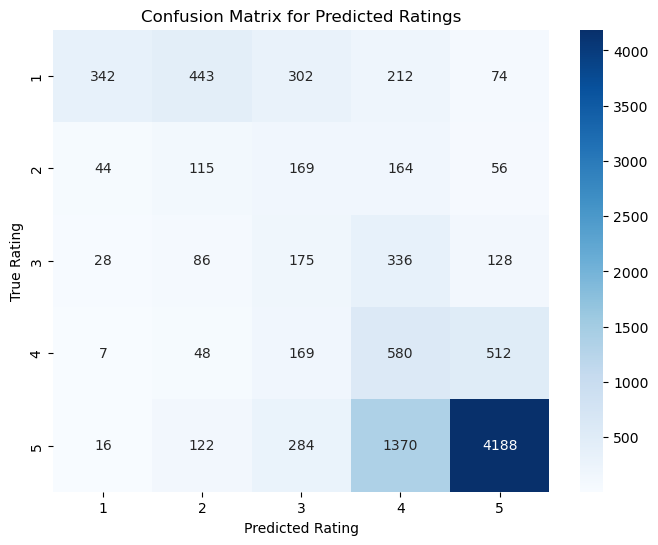

In [14]:
y_pred_rounded = y_pred.round().clip(1, 5).astype(int)

cm = confusion_matrix(y_test, y_pred_rounded)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix for Predicted Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.show()

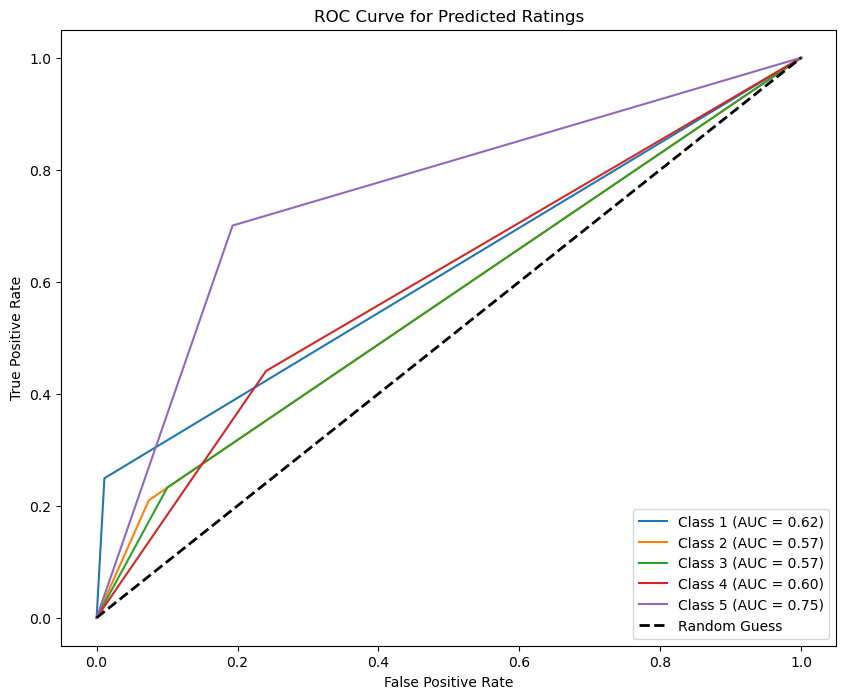

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred_rounded, classes=[1, 2, 3, 4, 5])

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.title('ROC Curve for Predicted Ratings')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


The evaluation of the model through the confusion matrix and ROC curve highlights both its strengths and weaknesses. From the confusion matrix, we observe that the model performs well in predicting polarized reviews. A significant proportion of reviews with true ratings of 4 and 5 are correctly classified within the high-rating range, while reviews with true ratings of 1 or 2 are accurately placed in the low-rating range. However, the model struggles with reviews in the mid-range (rating 3), contributing to an overall accuracy of 55.21%. While this accuracy is modest, the model demonstrates potential when ratings are grouped into broader categories: low (1–2), medium (3), and high (4–5), performing reasonably well in distinguishing between these sentiment tiers.

The ROC curve analysis further supports these findings, showing that the model is most effective at predicting reviews with a rating of 5, achieving a ROC-AUC score of 0.75. However, its performance diminishes for ratings of 1 and 4, with ROC-AUC scores of 0.62 and 0.6, respectively, indicating moderate success in these categories. The greatest challenge lies with ratings of 2 and 3, where the ROC-AUC scores drop to 0.52, suggesting near-random prediction performance and a lack of discriminatory power.

Together, these metrics reveal a model that performs well at identifying clear positive and negative sentiments but struggles with nuanced or mid-range ratings. This suggests room for improvement, particularly in handling ambiguous or borderline reviews. Potential strategies for enhancement include rebalancing the dataset, refining feature engineering, exploring ensemble methods, or employing advanced algorithms to better capture the complexities of the data.

## Discussion

This project aimed to explore clustering analysis on Amazon reviews in the video game category, using Natural Language Processing (NLP) techniques to uncover patterns and insights from customer feedback. While the process yielded valuable findings, several challenges and opportunities for improvement emerged during the course of the analysis.

#### Key Problems Identified
__High Dimensionality of Text Data__: Textual data, when converted into vectors, often results in high-dimensional feature spaces. This can lead to issues like clustering algorithms struggle to differentiate meaningful groupings due to sparsity and noise in the data.

__Cluster Interpretability__: While clustering provided groupings of reviews, interpreting the meaning of clusters and assessing their quality remains challenging. Clusters are often difficult to label without clear, consistent patterns in the grouped data.

#### Potential Improvements
__Incorporate Semantic Understanding__: Instead of relying solely on TF-IDF, incorporating semantic embedding models such as Word2Vec or BERT could capture the contextual meaning of words and improve vector representations.

__Dynamic Clustering__: Experimenting with clustering algorithms that adapt to the data, such as DBSCAN (density-based spatial clustering), can provide more flexible groupings, especially for datasets with varying cluster sizes and densities.

#### Future Methods to Explore
__Time-Based Analysis__: Incorporating temporal patterns into clustering could help track changes in customer preferences or sentiment over time, adding a dynamic element to the analysis.



### Citation

Bridging Language and Items for Retrieval and Recommendation
Yupeng Hou, Jiacheng Li, Zhankui He, An Yan, Xiusi Chen, Julian McAuley
arXiv
pdf (for using their dataset)

Bijoyan Das, Sarit Charkraborty, *An Improved Text Sentiment Classification Model Using TF-IDF and Next Word Negation*, 2013, https://arxiv.org/pdf/1806.06407
